In [10]:
from lib import data_loaders
from lib import dendra_berkeley

import missingno as msno

from dotenv import load_dotenv
import os
import requests
import pandas as pd
import time
import json

In [2]:
load_dotenv()
dendra_pass = os.getenv("DENDRA_PASS")
Dendra = data_loaders.Dendra(email="dragar@lynker.com", password=dendra_pass)

successfully authenticated


In [3]:
# parameters: start and end time
# Note the queries default to local time. Add a captial 'Z' to the end of the timestamp to indicate UTC and many functions have a parameter for local vs utc
begins_at = "2023-01-01T00:00:00"
ends_before = (
    dendra_berkeley.time_format()
)  # time_format without argument gives current datetime. #'2020-03-01T00:00:00'

## Get coordinates for preserve locations

In [4]:
# get location metadata for all stations in dangermond
all_preserve_station_ids = Dendra.list_stations(orgslug="tnc")

In [ ]:
# get coordinates for all station locations in the preserve
all_locs = {}

for id in all_preserve_station_ids:
    sm = Dendra.get_meta_station_by_id(
        id["_id"]
    )  # This will pull full datastream metadata in JSON format
    print(sm)
    try:
        station_name = sm["full_name"]
        geo = sm["geo"]["coordinates"]
        geo.append(sm["_id"])
        print(station_name, sm["_id"])
        all_locs[station_name] = geo
    except:
        print(f"no location data (or name) for {sm}")
        continue

In [6]:
df_all_locs = pd.DataFrame.from_dict(
    all_locs, orient="index", columns=["lon", "lat", "elev", "station_id_dendra"]
)
# df_all_locs.to_csv("./output/all_dangermond_locations.csv")

In [7]:
df_all_locs

,lon,lat,elev,station_id_dendra
Cistern Water Tank,-120.419400,34.490000,64078034a303bf7529cdb530,None
Cojo HQ Water Tank,-120.445200,34.458500,6390f04da9b6140fd21ce113,None
Dangermond Alegria,-120.424429,34.479621,161.450005,64dbe91cd0708704d6d53d8c
Dangermond Alexander Ramajal,-120.416129,34.532571,228.375007,64dbe9ce2148db3f6f481b1a
Dangermond Buckhorn 1,-120.384729,34.512955,243.303008,64dbe9c755264579ef3ea324
...,...,...,...,...
Santa Cruz Island Main Ranch South Well,-119.721636,33.995761,67,60ca468be59e3ba96d7911d1
Santa Cruz Island Nursery Weather Station,-119.676921,33.989439,105,63686470b055ac33a4843a58
Santa Cruz Island Pelican Pines,-119.684150,34.016050,101,63645ca25d4311382ce55686
Santa Cruz Island Prsoner Well Gauge,-119.684150,34.016050,5,63686563b055ac80f1843a5b


In [24]:
# locations for Groundwater Wells in the preserve,  uses the datastream instead of station
measurement = "WellDepth"
# measurement = "AirTemperature"
query_refinement = {"is_hidden": False}
measurement_list = []  # list of only datastreams that you wish to download data from

well_ids = Dendra.list_datastreams_by_measurement(
    measurement, "", [], "tnc", query_refinement
)

well_locs = {}

for ds in well_ids:
    dsm = Dendra.get_meta_datastream_by_id(
        ds["_id"]
    )  # This will pull full datastream metadata in JSON format
    station_name = dsm["station_lookup"]["name"]
    try:
        geo = dsm["geo"]["coordinates"]
        geo.append(ds["_id"])
        print(station_name, ds["name"], ds["_id"])
        well_locs[station_name] = geo
    except:
        print(f"no location data for {station_name}")
        continue

df_well_loc = pd.DataFrame.from_dict(
    well_locs, orient="index", columns=["lon", "lat", "elev", "station_id_dendra"]
)
# df_well_loc.to_csv("./output/well_locations.csv")

Dangermond Escondido 5 Depth to Groundwater 6511f67d2148db626248533e
Dangermond Buckhorn 2 Depth to Groundwater 6511f7e82148db3a1e485341
Dangermond Alegria Depth to Groundwater 6511f7e85526453a3c3edcd7
Dangermond Alexander Ramajal Depth to Groundwater 6511f7e8808187594cc93c0b
Dangermond Buckhorn 1 Depth to Groundwater 6511f7e8d070873fc4d574e2
Dangermond East Ramajal Depth to Groundwater 6511f7e90209692d22a0add0
Dangermond Diamond Corral Depth to Groundwater 6511f7e95526459d613edcd9
Dangermond Damsite Canyon Depth to Groundwater 6511f7e95c0d5fe521698416
Dangermond Cojo Canyon Depth to Groundwater 6511f7e9f1438dfeb44e11a9
Dangermond Escondido 3 Depth to Groundwater 6511f7ea55264589773edcdb
Dangermond Escondido 1 Depth to Groundwater 6511f7ea5c0d5f9de3698418
Dangermond Escondido 2 Depth to Groundwater 6511f7ea8081871abec93c0d
Dangermond Escondido 3B Depth to Groundwater 6511f7ea8081871bfbc93c0f
Dangermond Escondido 4 Depth to Groundwater 6511f7ead07087d401d574e5
Dangermond Gaspar 2 Depth 

In [25]:
well_ids

[{'_id': '6511f67d2148db626248533e', 'name': 'Depth to Groundwater'},
 {'_id': '6511f7e82148db3a1e485341', 'name': 'Depth to Groundwater'},
 {'_id': '6511f7e85526453a3c3edcd7', 'name': 'Depth to Groundwater'},
 {'_id': '6511f7e8808187594cc93c0b', 'name': 'Depth to Groundwater'},
 {'_id': '6511f7e8d070873fc4d574e2', 'name': 'Depth to Groundwater'},
 {'_id': '6511f7e90209692d22a0add0', 'name': 'Depth to Groundwater'},
 {'_id': '6511f7e95526459d613edcd9', 'name': 'Depth to Groundwater'},
 {'_id': '6511f7e95c0d5fe521698416', 'name': 'Depth to Groundwater'},
 {'_id': '6511f7e9f1438dfeb44e11a9', 'name': 'Depth to Groundwater'},
 {'_id': '6511f7ea55264589773edcdb', 'name': 'Depth to Groundwater'},
 {'_id': '6511f7ea5c0d5f9de3698418', 'name': 'Depth to Groundwater'},
 {'_id': '6511f7ea8081871abec93c0d', 'name': 'Depth to Groundwater'},
 {'_id': '6511f7ea8081871bfbc93c0f', 'name': 'Depth to Groundwater'},
 {'_id': '6511f7ead07087d401d574e5', 'name': 'Depth to Groundwater'},
 {'_id': '6511f7eb21

## Get complete datastreams for all stations in the preserve

In [46]:
# this requests a lot of data. Use carefully.
for stn in all_preserve_station_ids:  # for each station
    # print(stn)
    stn_name = stn["name"].replace(" ", "_")
    print(stn_name)

    # Option 1: get all datastreams associated with this station
    # stn_dstreams = Dendra.list_datastreams_by_station_id(station_id=stn["_id"])

    # Option 2: get ONLY Ground Water datastreams, if any exist for the station
    stn_dstreams = Dendra.list_datastreams_by_medium_variable(
        medium="GroundWater", station_id=stn["_id"]
    )

    if stn_dstreams:  # if not empty

        # make directory to store station datastreams
        os.makedirs(f"./output/tnc_datastreams/{stn_name}/", exist_ok=True)

        # request data for each datastream
        stn_dstreams_data = {}

        for loc in stn_dstreams:
            # request data for each datastream associated with the station
            print(f"making request for: {loc['_id']}")
            res, dstream_name = Dendra.get_datapoints(
                begins_at="1980-01-01T00:00:00",
                datastream_id=loc["_id"],
                ends_before="2024-05-01T00:00:00",
                name="other",
            )

            # serialize vaild reponses as Parquet
            if res is not None:

                dstream_name = dstream_name.replace(
                    "/", "_"
                )  # must not have slash in filename

                print(f"{dstream_name=}")
                res.to_parquet(
                    f"./output/tnc_datastreams/{
                        stn_name}/{dstream_name}.parquet"
                )

                # request metadata for each datastream
                dsm = Dendra.get_meta_datastream_by_id(
                    datastream_id=loc["_id"],
                )
                # create filename based on stn name and dstream name
                metadata_fname = dsm["name"].replace(
                    " ", "_") + "_Metadata.json"
                metadata_fname = metadata_fname.replace(
                    "/", "_"
                )  # must not have slash in filename

                # Convert metadata dict and write JSON object to file
                with open(
                    f"./output/tnc_datastreams/{
                        stn_name}/{metadata_fname}", "w"
                ) as outfile:
                    json.dump(dsm, outfile)

        time.sleep(25)  # reduce server load

Cistern_Water_Tank
Cojo_HQ_Water_Tank
Dangermond_Alegria
making request for: 6511f7e85526453a3c3edcd7
dstream_name='DangermondAlegria_Depth_to_Groundwater'
making request for: 65d79c9bd5300308d8349b48
dstream_name='DangermondAlegria_Groundwater_Elevation'
making request for: 64fa48e6808187b50ec92238
dstream_name='DangermondAlegria_Well_Water_Level'
making request for: 64dd3e6a0209697bd9a07565
dstream_name='DangermondAlegria_Well_Water_Level_xle_lev'
making request for: 64dd3e6b808187cc3fc90512
dstream_name='DangermondAlegria_Well_Water_Level_xlsx'
making request for: 64fa48e6d070879ef7d55bcb
dstream_name='DangermondAlegria_Well_Water_Temperature'
making request for: 64dd3e6bd0708717b5d53f21
dstream_name='DangermondAlegria_Well_Water_Temperature_xle_lev'
making request for: 64dd3e6b55264579523ea4e5
dstream_name='DangermondAlegria_Well_Water_Temperature_xlsx'
Dangermond_Alexander_Ramajal
making request for: 6511f7e8808187594cc93c0b
dstream_name='DangermondAlexanderramajal_Depth_to_Ground

In [11]:
Dendra.list_datastreams_by_station_id(station_id="64dbe9c8d070876630d53d90")

[{'_id': '6511f7ea5c0d5f9de3698418', 'name': 'Depth to Groundwater'},
 {'_id': '65d79cb2d530031963349b58', 'name': 'Groundwater Elevation'},
 {'_id': '64fa48ebf1438db10b4df8ba', 'name': 'Well Water Level'},
 {'_id': '64dd3e72552645ea5d3ea4f0', 'name': 'Well Water Level xle/lev'},
 {'_id': '64dd3e72d07087fcd9d53f2c', 'name': 'Well Water Level xlsx'},
 {'_id': '64fa48ebd07087cf9ad55bcf', 'name': 'Well Water Temperature'},
 {'_id': '64dd3e722148db02fb481d41', 'name': 'Well Water Temperature xle/lev'},
 {'_id': '64dd3e728081877064c90520', 'name': 'Well Water Temperature xlsx'}]

In [12]:
dsm = Dendra.get_meta_datastream_by_id(
    datastream_id="6511f7ea5c0d5f9de3698418",
)

In [13]:
dsm

{'_id': '6511f7ea5c0d5f9de3698418',
 'attributes': {'rp_height': 1.8, 'well_elevation_m': 295.69500946223997},
 'datapoints_config': [{'begins_at': '2000-01-01T08:00:00.000Z',
   'params': {},
   'path': '/dendra/datapoints',
   'actions': {'evaluate': 'v = @{sensor_depth} ==null ? null : number(number(@{sensor_depth}) - va[1] - number(@{rp_height}))'}}],
 'derived_from_datastream_ids': ['64fa48ebf1438db10b4df8ba'],
 'description': 'Ground surface to groundwater surface distance (ft) calculated from Well Water Level (derived) stream and manually input sensor depths.',
 'is_enabled': True,
 'is_geo_protected': False,
 'is_hidden': False,
 'name': 'Depth to Groundwater',
 'source_type': 'sensor',
 'state': 'ready',
 'station_id': '64dbe9c8d070876630d53d90',
 'terms': {'dq': {'Measurement': 'WellDepth', 'Purpose': 'ReadytoUse'},
  'ds': {'Medium': 'GroundWater', 'Variable': 'Distance'},
  'dt': {'Unit': 'Foot'}},
 'derivation_description': "Calculated distance from surface to groundwater 

In [47]:
# measurement = "WellDepth"
# # measurement = "AirTemperature"
# query_refinement = {"is_hidden": False}
# measurement_list = []  # list of only datastreams that you wish to download data from

# ds_list = Dendra.list_datastreams_by_measurement(
#     measurement, "", [], "tnc", query_refinement
# )

# for ds in ds_list:
#     dsm = Dendra.get_meta_datastream_by_id(
#         ds["_id"]
#     )  # This will pull full datastream metadata in JSON format
#     station_name = dsm["station_lookup"]["name"]
#     print(station_name, ds["name"], ds["_id"])
#     measurement_list.append(ds["_id"])

no numeric data to plot
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 0 entries
Data columns (total 2 columns):
 #   Column                                    Non-Null Count  Dtype              
---  ------                                    --------------  -----              
 0   timestamp_utc                             0 non-null      datetime64[ns, UTC]
 1   DangermondBuckhorn2_Depth_to_Groundwater  0 non-null      object             
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 108.0+ bytes
None
no numeric data to plot
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 0 entries
Data columns (total 2 columns):
 #   Column                                  Non-Null Count  Dtype              
---  ------                                  --------------  -----              
 0   timestamp_utc                           0 non-null      datetime64[ns, UTC]
 1   DangermondAlegria_Depth_to_Groundwater  0 non-null      object             
dtypes: datetime64[ns, UTC](1), 

/Users/dillonragar/miniconda3/envs/tnc_env/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


'\nDR: Initial plotting of groundwater well data shows most sites have discontinuous POR as well as \nsensor drift, offset changes (likely due to changing sensor depth), and spikes (perhaps due to \npumping for sampling or removal). These datastreams collected here are Well Water Depth (i.e. DTW, WWD) \n\nPer J.E. -> Depth to grounwater has not been barometrically corrected. \nSo we will likely need to accesss the raw Solinst data in order to do so. \n\nTODO: check that Dendra is actually returning the DTW datastreams.\n'

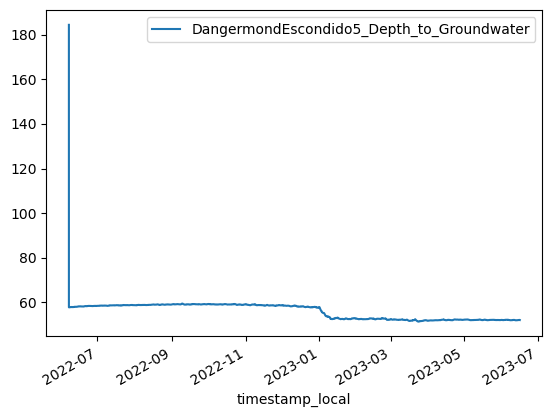

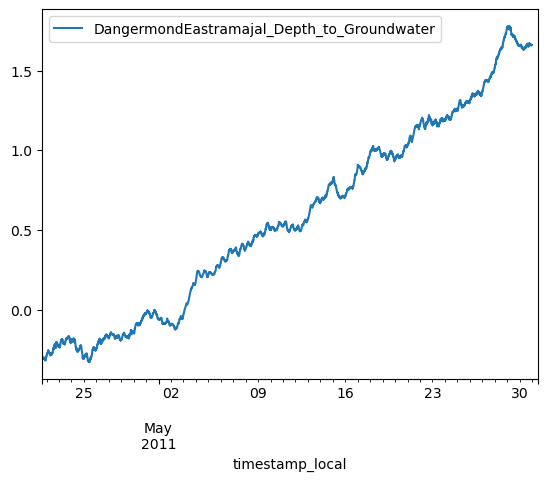

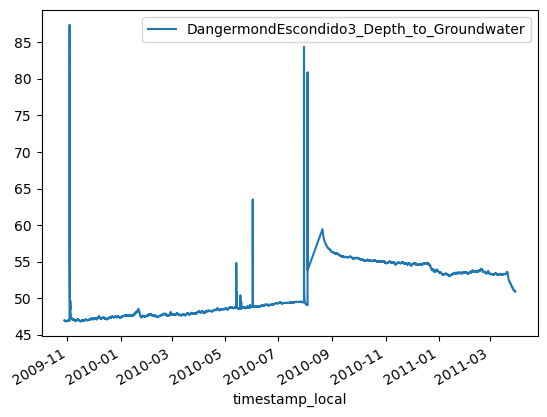

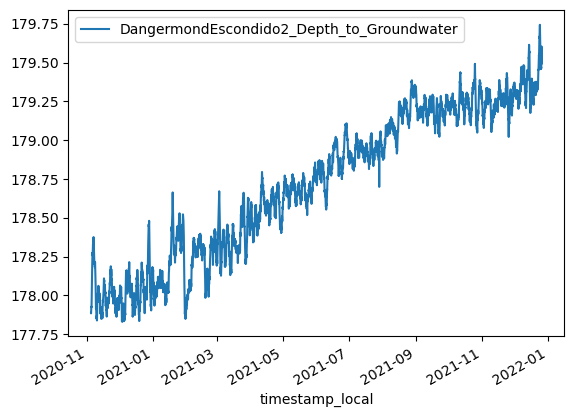

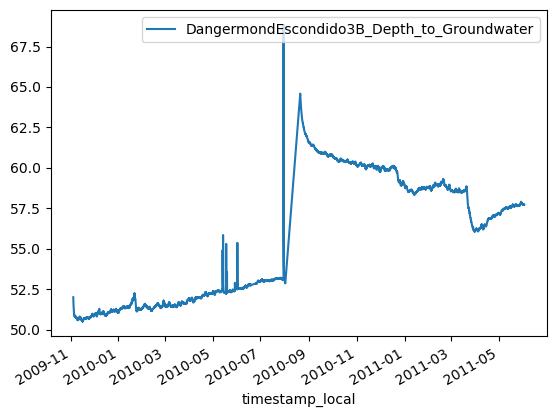

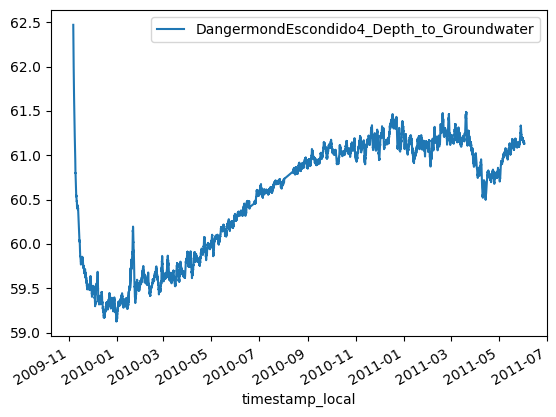

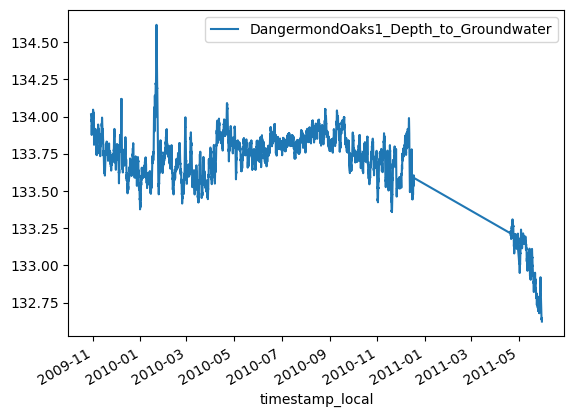

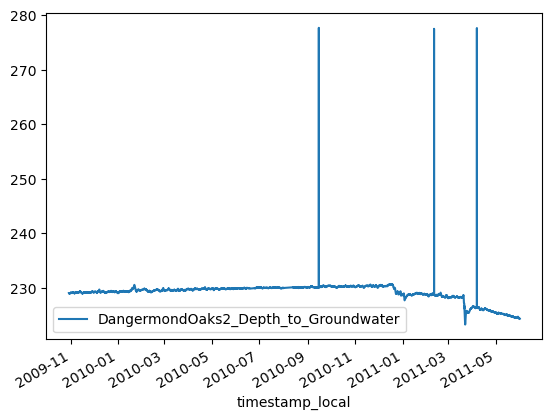

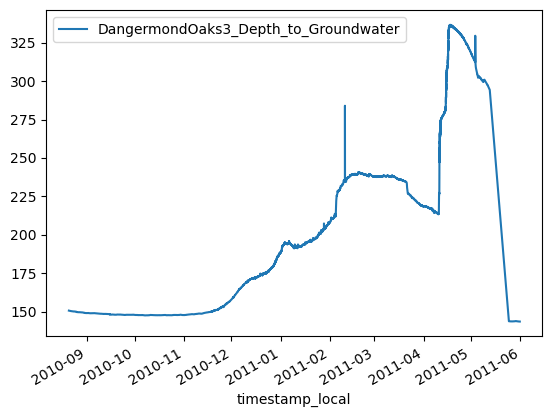

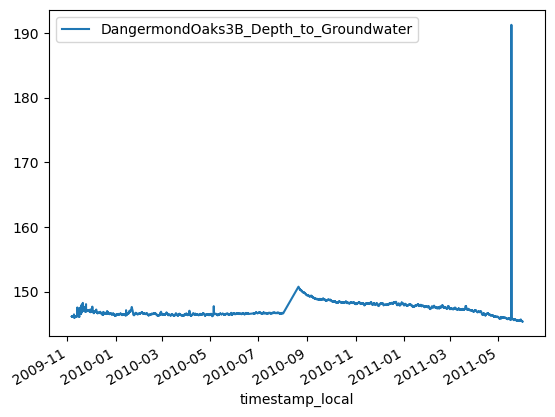

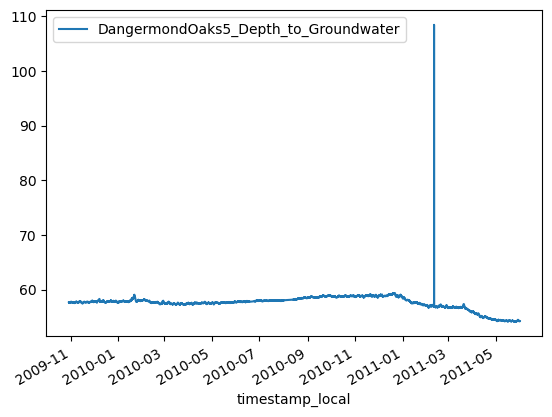

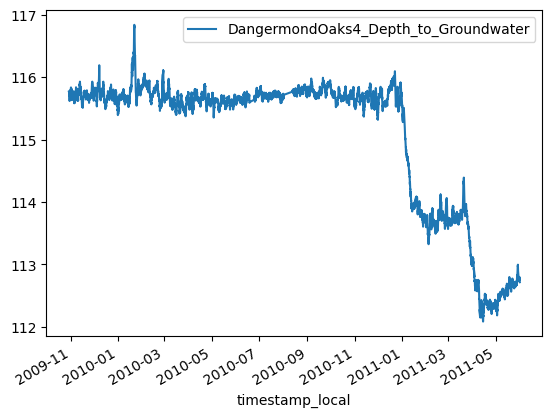

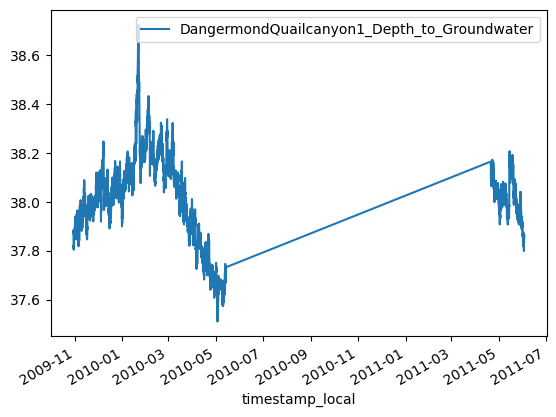

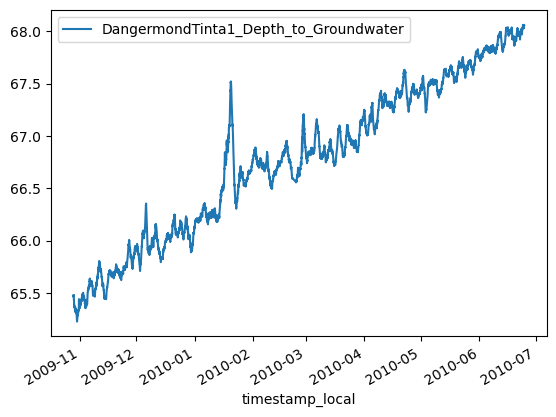

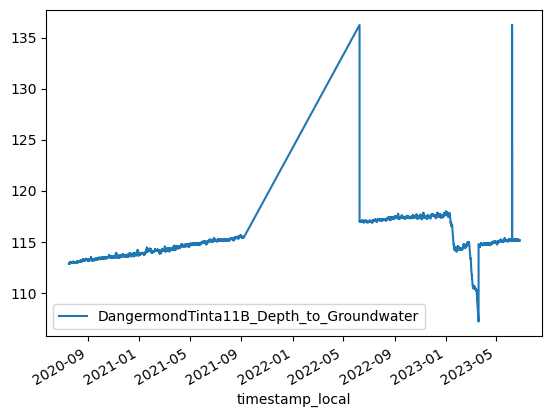

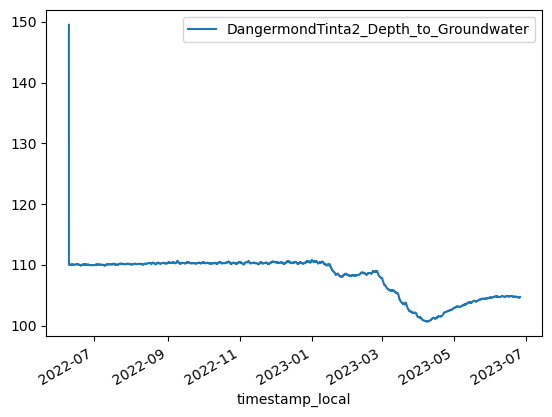

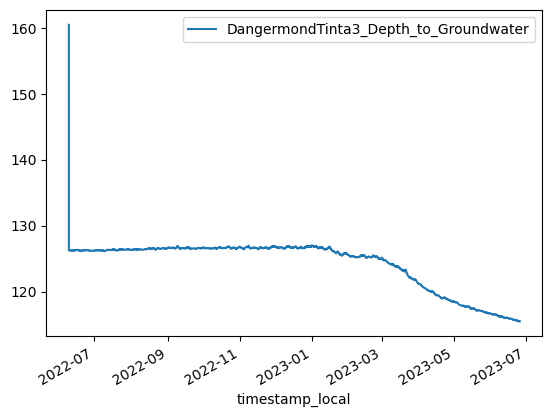

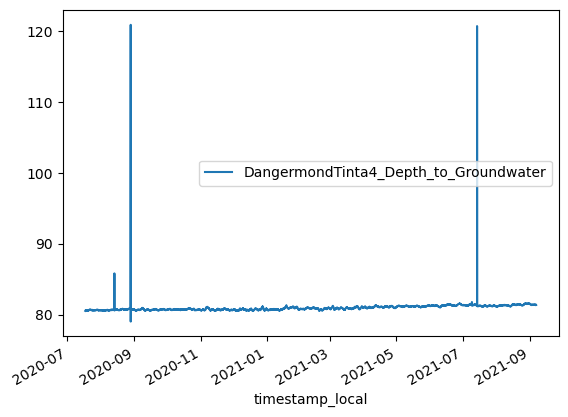

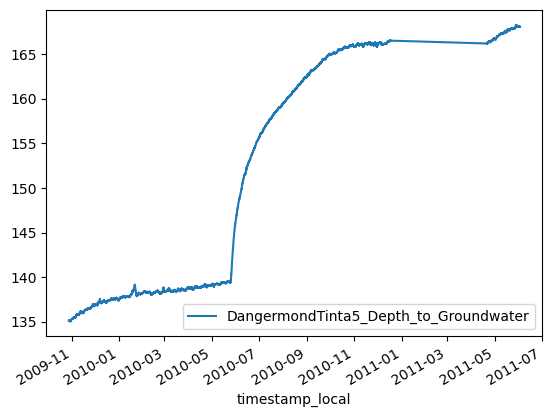

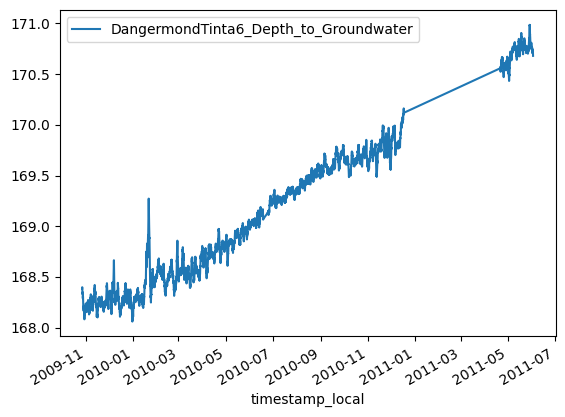

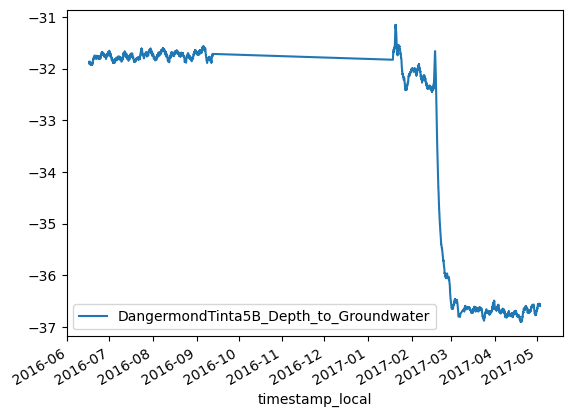

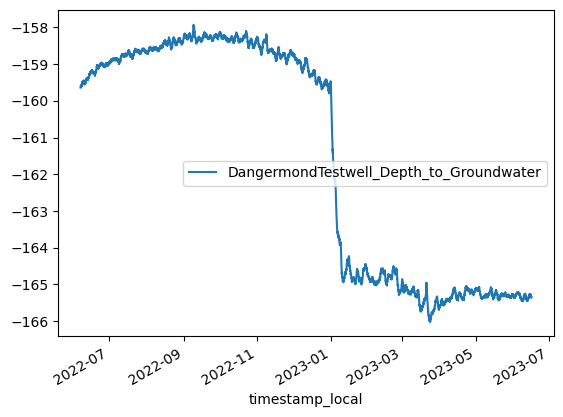

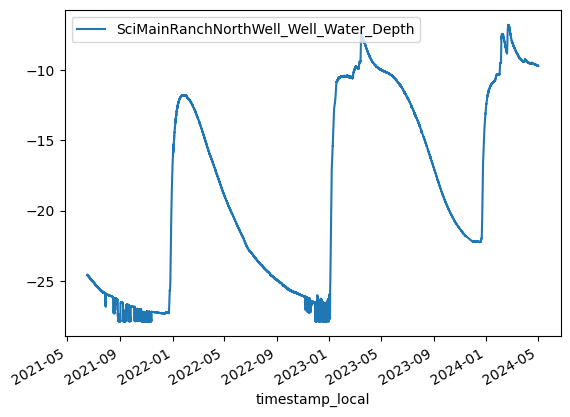

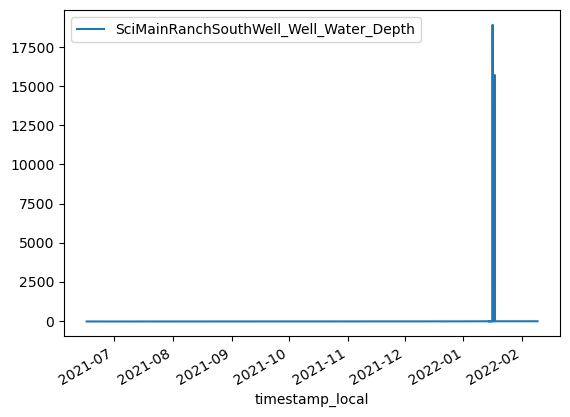

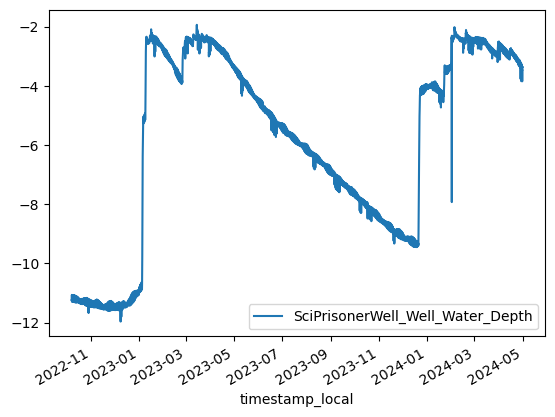

In [95]:
for df in all_datastreams.values():
    try:
        df.drop(columns="timestamp_utc").plot()
    except Exception as e:
        print(e)
        print(df.info())
        continue

"""
DR: Initial plotting of groundwater well data shows most sites have discontinuous POR as well as 
sensor drift, offset changes (likely due to changing sensor depth), and spikes (perhaps due to 
pumping for sampling or removal). These datastreams collected here are Well Water Depth (i.e. DTW, WWD) 

Per J.E. -> Depth to grounwater has not been barometrically corrected. 
So we will likely need to accesss the raw Solinst data in order to do so. 

TODO: check that Dendra is actually returning the DTW datastreams.
"""

In [97]:
all_datastreams["60ca6d7658d559b6ca49c1fd"]

,timestamp_utc,SciMainRanchSouthWell_Well_Water_Depth,q
timestamp_local,,,
2021-06-16 10:05:00,2021-06-16 18:05:00+00:00,-28.653633,NaN
2021-06-16 10:10:00,2021-06-16 18:10:00+00:00,-28.617633,NaN
2021-06-16 10:15:00,2021-06-16 18:15:00+00:00,-28.676633,NaN
2021-06-16 10:25:00,2021-06-16 18:25:00+00:00,-28.705633,NaN
2021-06-16 10:30:00,2021-06-16 18:30:00+00:00,-28.682633,NaN
...,...,...,...
2022-02-09 02:05:00,2022-02-09 10:05:00+00:00,-14.918700,"{'annotation_ids': [{'_bsontype': 'ObjectID', ..."
2022-02-09 02:10:00,2022-02-09 10:10:00+00:00,-14.922700,"{'annotation_ids': [{'_bsontype': 'ObjectID', ..."
2022-02-09 02:15:00,2022-02-09 10:15:00+00:00,-14.923700,"{'annotation_ids': [{'_bsontype': 'ObjectID', ..."


In [ ]:
# fetch all datastreams for single well.
# escondido 2:  6511f7ea8081871abec93c0d

In [ ]:
meta = Dendra.get_meta_datastream_by_id("6511f7ea8081871abec93c0d")

In [ ]:
# request data for single datastream ID
res = Dendra.get_datapoints(
    begins_at="2023-01-01T00:00:00",
    datastream_id=measurement_list[53],
    ends_before="2024-05-01T00:00:00",
    name="other",
)